In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pickle

import os
from helpers.datasets import *
from helpers.plotting import *

plt.style.use("science.mplstyle")
cm = matplotlib.cm.get_cmap('Greens')
from matplotlib.backends.backend_pdf import PdfPages as pp

np.random.seed(8)

In [2]:
# directories
feta_dir = "/global/home/users/rrmastandrea/FETA/"

STS_config_string = f"LHCO_STS_3prong/"
STS_dir = os.path.join(feta_dir, STS_config_string, "data")
os.makedirs(STS_dir, exist_ok=True)

In [3]:
# dataset generation parameters


"""
context_endpoints = (2500, 4500)
bands_dict = {"ob1": [2500, 2900],
              "sb1": [2900, 3300],
              "sr" : [3300, 3700],
              "sb2": [3700, 4100],
            "ob2": [4100, 4500]}
              """

context_endpoints = (1500, 5500)
bands_dict = {"sb1": [1500, 3300],
              "sr" : [3300, 3700],
              "sb2": [3700, 5500],
             }            
              
              
print("Generating datasets...")

bands_to_analyze = ["sb1", "sr", "sb2"]

df_sim = get_lhco(sim_type = "herwig")
data_sim = select_lhco_features(df_sim, feature_type = 0).to_numpy()

df_dat = get_lhco(sim_type = "pythia")
data_dat = select_lhco_features(df_dat, feature_type = 0).to_numpy()

#df_signal = get_lhco(sim_type = "pythia", sm = "signal")
#data_signal = select_lhco_features(df_signal, feature_type = 0).to_numpy()
df_signal = get_lhco(sim_type = "3_prong", sm = "signal")
data_signal = select_lhco_features(df_signal, feature_type = 0).to_numpy()

# add an extra column to keep track of sig, bkg information
data_sim = np.hstack((data_sim, np.zeros((len(data_sim), 1))))
data_dat = np.hstack((data_dat, np.zeros((len(data_dat), 1))))
data_signal = np.hstack((data_signal, np.ones((len(data_signal), 1))))

print("SIM shape:", data_sim.shape)
print("DAT shape:", data_dat.shape)
print("SIGNAL shape:", data_signal.shape)



n_features = 6

Generating datasets...
events_anomalydetection_herwig_features.h5
events_anomalydetection_v2.features.h5
events_anomalydetection_Z_XY_qqq.features.h5
SIM shape: (999986, 7)
DAT shape: (999881, 7)
SIGNAL shape: (99969, 7)


In [4]:
def pull_from_mass_range(dataset, mass_ranges):

        """
        mass_ranges is a list of lists [low_bound, high_bound]
        """

        selected_data = []

        for mass_range in mass_ranges:
            loc = np.where((dataset[:, 5] >= mass_range[0]) & (dataset[:, 5] < mass_range[1]))[0]
            selected_data.append( dataset[loc, :] )
        selected_data = np.concatenate(selected_data)
        np.random.shuffle(selected_data)

        return selected_data

def pull_n_signal_events(n, sig_dataset):
    
    selected_sig_indices = np.random.choice(sig_dataset.shape[0], size=n, replace=False)
    selected_sig_events = sig_dataset[selected_sig_indices]
    
    return(selected_sig_events)

## Count number of events ber band

In [5]:
herwig_bkg_dict = {}
pythia_bkg_dict = {}
pythia_sig_dict = {}

num_sig_pythia_events = {}
num_bkg_pythia_events = {}

for b in bands_to_analyze:
    print(f"Number of events in band {b}:")
    loc = pull_from_mass_range(data_sim, [bands_dict[b]])
    herwig_bkg_dict[b] = loc
    print(f"Herwig bkg: {len(loc)}")
    
    loc = pull_from_mass_range(data_dat, [bands_dict[b]])
    pythia_bkg_dict[b] = loc
    num_bkg_pythia_events[b] = len(loc)
    print(f"Pythia bkg: {len(loc)}")
    
    loc = pull_from_mass_range(data_signal, [bands_dict[b]])
    pythia_sig_dict[b] = loc
    num_sig_pythia_events[b] = len(loc)
    print(f"Pythia sig: {len(loc)}")
          
    print()
    



Number of events in band sb1:
Herwig bkg: 728210
Pythia bkg: 734634
Pythia sig: 9308

Number of events in band sr:
Herwig bkg: 121978
Pythia bkg: 121339
Pythia sig: 79781

Number of events in band sb2:
Herwig bkg: 141038
Pythia bkg: 135990
Pythia sig: 10863



## Pull from sb1 -> sb2 to visualize and get column rescales

SIM shape: (991226, 7)
DAT shape: (991963, 7)
SIGNAL shape: (99952, 7)


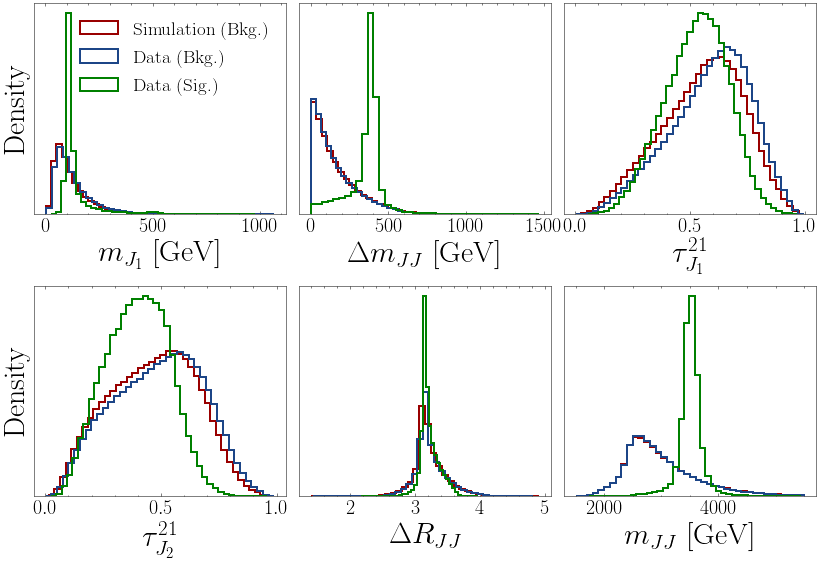

In [6]:
pulls = [bands_dict[b] for b in bands_to_analyze]

in_range_herwig_bkg = pull_from_mass_range(data_sim, pulls)
in_range_pythia_bkg = pull_from_mass_range(data_dat, pulls)
in_range_pythia_sig = pull_from_mass_range(data_signal, pulls)


# list of (min, max) to preprocess every column
col_minmax = []
for col in range(n_features):
    col_minmax.append([np.min(in_range_herwig_bkg[:, col]), np.max(in_range_herwig_bkg[:, col])])
    

print("SIM shape:", in_range_herwig_bkg.shape)
print("DAT shape:", in_range_pythia_bkg.shape)
print("SIGNAL shape:", in_range_pythia_sig.shape)

feature_labels = [r"$f_0$", r"$f_1$", r"$f_2$", r"$f_3$", r"$f_4$", r"$f_5$"]
feature_labels = [r"$m_{J_1}$ [GeV]", r"$\Delta m_{JJ}$ [GeV]", r"$\tau^{21}_{J_1}$", r"$\tau^{21}_{J_2}$", 
                  r"$\Delta R_{JJ}$", r"$m_{JJ}$ [GeV]"] 


# Plot some features
#fig = plot_feature_histograms(in_range_herwig_bkg, in_range_pythia_bkg, 40, n_features, feature_labels, 
#                              third_plot = in_range_pythia_sig)
#fig.show()

dpi = 800

bins = 40
sim_color = "#990000"
dat_color = "#1c4587"
linewidth = 2

fig, ax = plt.subplots(2, 3, figsize = (12, 8))
fig.subplots_adjust(right=0.8, left = 0.2)

for ax_x in range(2):
    for ax_y in range(3):
        i = ax_x*3 + ax_y
        ax[ax_x, ax_y].hist(in_range_herwig_bkg[:,i], bins = bins, density = True, label = "Simulation (Bkg.)", histtype = "step", color = sim_color, linewidth = linewidth)
        ax[ax_x, ax_y].hist(in_range_pythia_bkg[:,i], bins = bins, density = True, label = "Data (Bkg.)", histtype = "step", color = dat_color, linewidth = linewidth)
        ax[ax_x, ax_y].hist(in_range_pythia_sig[:,i], bins = bins, density = True, label = "Data (Sig.)", histtype = "step", color = "green", linewidth = linewidth)
    
        ax[ax_x, ax_y].set_xlabel(feature_labels[i], fontsize = 30)
        ax[ax_x, ax_y].tick_params(axis='both', which='major', labelsize=20)
        ax[ax_x, ax_y].set_yticks([])

ax[0,0].set_ylabel("Density", fontsize = 30)  
ax[1,0].set_ylabel("Density", fontsize = 30) 
ax[0,0].legend(fontsize = 19, loc = "upper right")  
plt.tight_layout()

dpi = 800


#fig.savefig(f"paper_plots/features.pdf", dpi = dpi)




## Generate a standard test set and write out

This is the first 20k signal, 20k background events IN THE SR


(20000, 6)


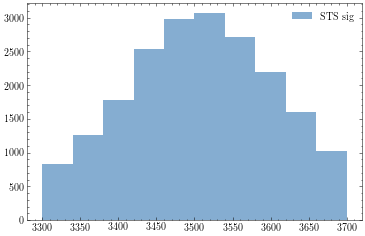

[1.08956001e+02 3.95438019e+02 1.83133811e-01 2.34884039e-01
 3.13677979e+00 3.52986694e+03]
[8.78901978e+01 4.54921814e+02 4.88065094e-01 4.65882450e-01
 3.11865163e+00 3.46049561e+03]


In [7]:
"""n_sts = 20000

sts_bkg = pythia_bkg_dict["sr"][:n_sts,:-1]
sts_sig = pythia_sig_dict["sr"][:n_sts,:-1]

print(sts_bkg.shape, sts_sig.shape)


plt.figure()
plt.hist(sts_bkg[:,-1], alpha = 0.5, label = "STS bkg")
plt.hist(sts_sig[:,-1], alpha = 0.5, label = "STS sig")
plt.legend()
plt.show()

print(sts_bkg[0])
print(sts_bkg[1])
print(sts_sig[0])
print(sts_sig[1])"""



n_sts = 20000

sts_sig = pythia_sig_dict["sr"][:n_sts,:-1]

print(sts_sig.shape)


plt.figure()
plt.hist(sts_sig[:,-1], alpha = 0.5, label = "STS sig")
plt.legend()
plt.show()


print(sts_sig[0])
print(sts_sig[1])

In [8]:
#np.save(os.path.join(STS_dir, "STS_bkg.npy"), sts_bkg)
np.save(os.path.join(STS_dir, "STS_sig.npy"), sts_sig)
np.save(os.path.join(STS_dir, "col_minmax.npy"), col_minmax)


print(pythia_sig_dict["sr"].shape)

(79781, 7)


## Generate the supervised dataset

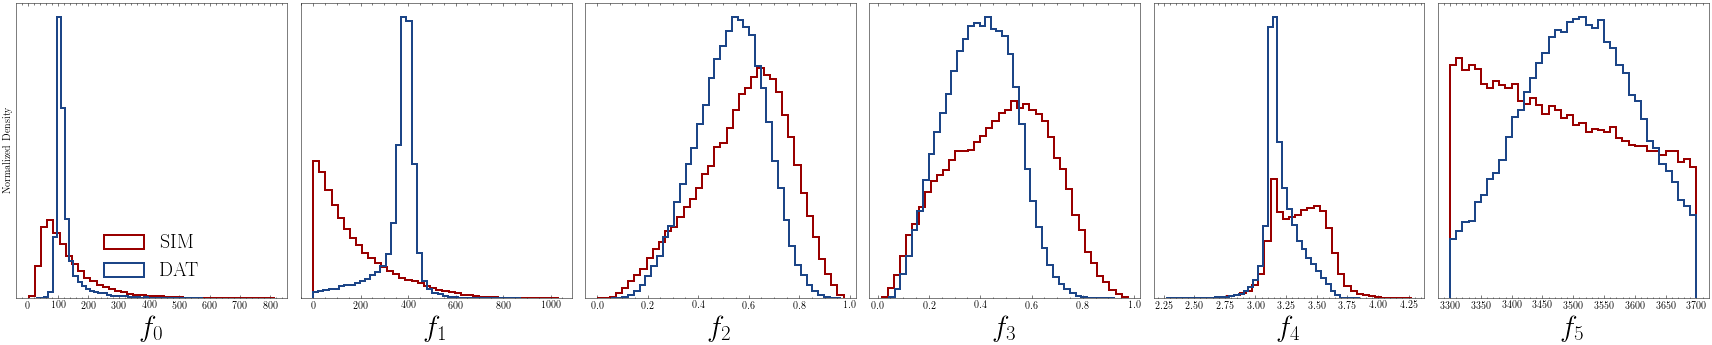

In [9]:
"""

true_sup_bkg = pythia_bkg_dict["sr"][n_sts:,:-1]
true_sup_sig = pythia_sig_dict["sr"][n_sts:,:-1]

feature_labels = [r"$f_0$", r"$f_1$", r"$f_2$", r"$f_3$", r"$f_4$", r"$f_5$"]


fig = plot_feature_histograms(true_sup_bkg, true_sup_sig, 40, n_features, feature_labels)
fig.show()

np.save(os.path.join(STS_dir, "true_sup_bkg.npy"), true_sup_bkg)
np.save(os.path.join(STS_dir, "true_sup_sig.npy"), true_sup_sig)
"""

#n_left = 55299
n_left = 59781 # for 3-prong signal

true_sup_bkg = pythia_bkg_dict["sr"][:n_left,:-1]
true_sup_sig = pythia_sig_dict["sr"][n_sts:,:-1]

feature_labels = [r"$f_0$", r"$f_1$", r"$f_2$", r"$f_3$", r"$f_4$", r"$f_5$"]


fig = plot_feature_histograms(true_sup_bkg, true_sup_sig, 40, n_features, feature_labels)
fig.show()

np.save(os.path.join(STS_dir, "true_sup_bkg.npy"), true_sup_bkg)
np.save(os.path.join(STS_dir, "true_sup_sig.npy"), true_sup_sig)


## Save out the nonSTS

This is a little subtle because although we only pulled the STS from the SR, we need to save out only a portion of the SB to get the proper ratios of events in SB1/SR/SB2

In [11]:
"""
pythia_bkg_nonSTS = {}
pythia_sig_nonSTS = {}

frac_pythia_sig_dropped = n_sts / num_sig_pythia_events["sr"]
frac_pythia_bkg_dropped = n_sts / num_bkg_pythia_events["sr"]


for b in bands_to_analyze:
    num_drop_bkg = int(frac_pythia_bkg_dropped*num_bkg_pythia_events[b])
    pythia_bkg_nonSTS[b] = pythia_bkg_dict[b][num_drop_bkg:]
    print(f"Dropping {num_drop_bkg} bkg events from band {b}")
    
    
    num_drop_sig = int(frac_pythia_sig_dropped*num_sig_pythia_events[b])
    pythia_sig_nonSTS[b] = pythia_sig_dict[b][num_drop_sig:]
    print(f"Dropping {num_drop_sig} sig events from band {b}")
    
pickle.dump( herwig_bkg_dict, open( "post_STS_wide/herwig_bkg_dict.p", "wb" ) )
#pickle.dump( pythia_bkg_nonSTS, open( "post_STS_wide/pythia_bkg_nonSTS.p", "wb" ) )
#pickle.dump( pythia_sig_nonSTS, open( "post_STS_wide/pythia_sig_nonSTS.p", "wb" ) )
"""

pythia_sig_nonSTS = {}

frac_pythia_sig_dropped = n_sts / num_sig_pythia_events["sr"]

for b in bands_to_analyze:
    
    num_drop_sig = int(frac_pythia_sig_dropped*num_sig_pythia_events[b])
    pythia_sig_nonSTS[b] = pythia_sig_dict[b][num_drop_sig:]
    print(f"Dropping {num_drop_sig} sig events from band {b}")
    
  
pickle.dump( herwig_bkg_dict, open( "post_STS_wide_3prong/herwig_bkg_dict.p", "wb" ) )
pickle.dump( pythia_bkg_dict, open( "post_STS_wide_3prong/pythia_bkg.p", "wb" ) )
pickle.dump( pythia_sig_nonSTS, open( "post_STS_wide_3prong/pythia_sig_nonSTS.p", "wb" ) )




Dropping 2333 sig events from band sb1
Dropping 19999 sig events from band sr
Dropping 2723 sig events from band sb2


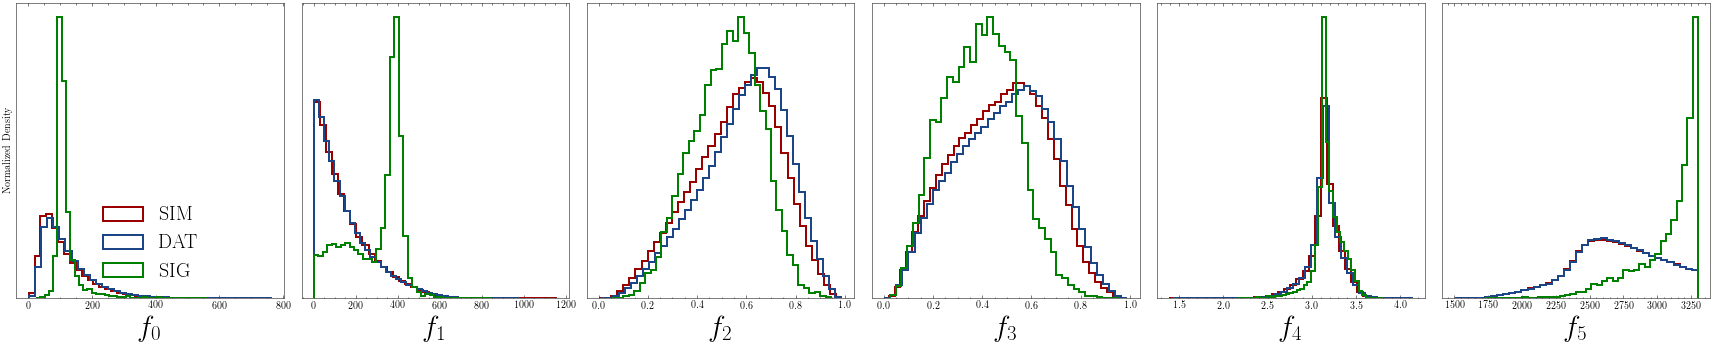

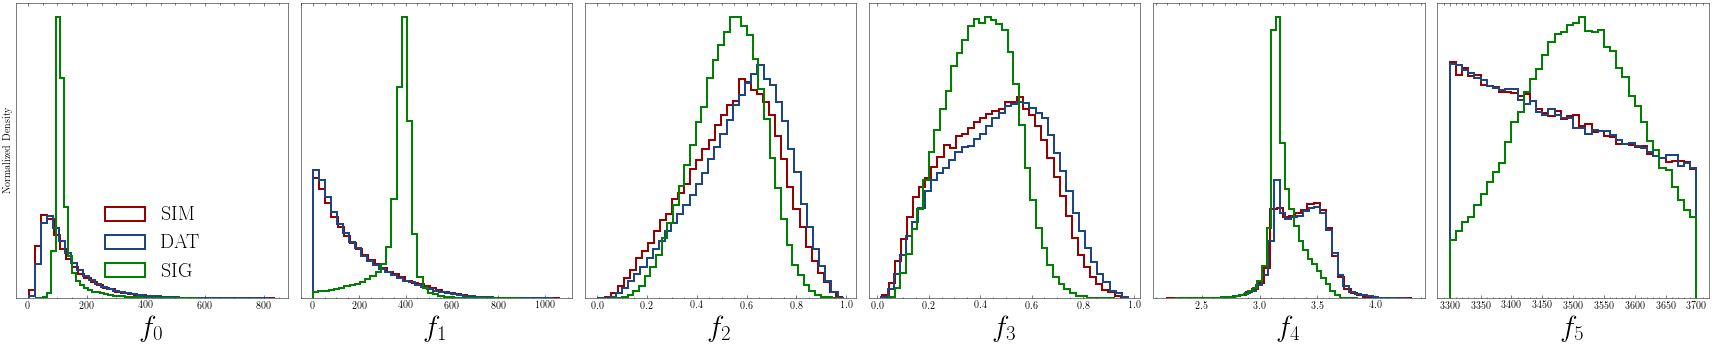

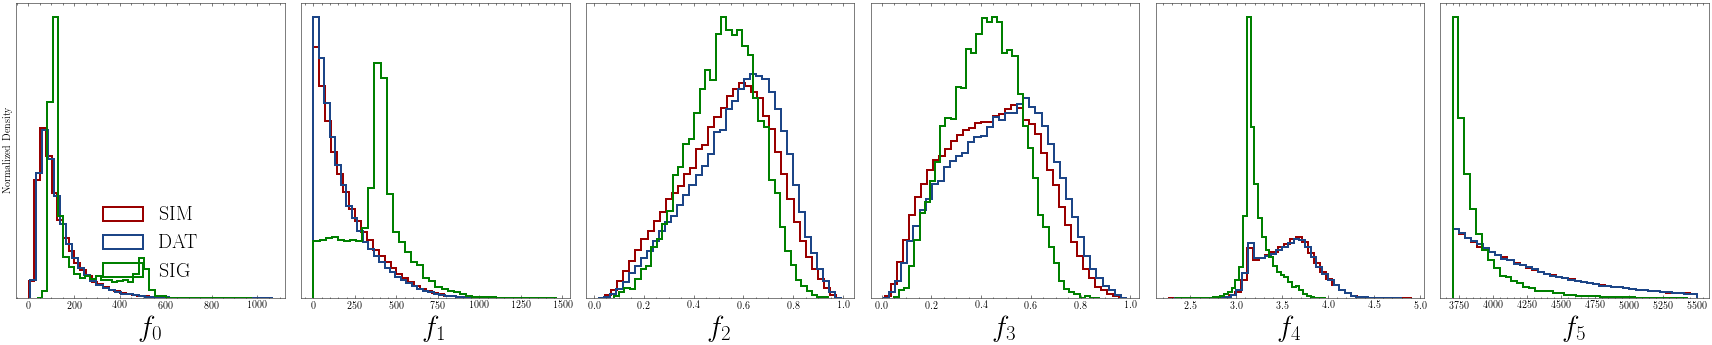

In [12]:
for b in bands_to_analyze:


    loc_pulls = [bands_dict[b]]

    loc_in_range_herwig_bkg = pull_from_mass_range(data_sim, loc_pulls)
    loc_in_range_pythia_bkg = pull_from_mass_range(data_dat, loc_pulls)
    loc_in_range_pythia_sig = pull_from_mass_range(data_signal, loc_pulls)


   
    # Plot some features
    fig = plot_feature_histograms(loc_in_range_herwig_bkg, loc_in_range_pythia_bkg, 40, n_features, feature_labels, 
                                  third_plot = loc_in_range_pythia_sig)
    fig.show()

